In [139]:
## CE 295 - Energy Systems and Control
#   HW 3 : Optimal Economic Dispatch in Distribution Feeders with Renewables
#   Franklin Zhao, SID 3033030808
#   Prof. Moura
#   Last updated: MARCH 12, 2018
# ZHAO_FRANKLIN_HW3.ipynb

################
## Python 3.6 ##
################

import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *
import pandas as pd
import seaborn as sns

# Plot configurations
%matplotlib inline
sns.set()
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rc('text', usetex=True)

In [140]:
# Import data

#####################################################
## Note: I've divided the .xlxs file into seperate ## 
##       .csv files to import data using pandas    ##
##       rather than just hard code the numbers.   ##
#####################################################

node = pd.read_csv('node-data.csv', index_col=0)
resistance = pd.read_csv('resistance.csv', index_col=0)
reactance = pd.read_csv('reactance.csv', index_col=0)
maxCurerent = pd.read_csv('max-current.csv', index_col=0)
Amatrix = pd.read_csv('Amatrix.csv', index_col=0)

In [141]:
## 13 Node IEEE Test Feeder Parameters

### Node (aka Bus) Data
# l_j^P: Active power consumption [MW]
l_P = np.array(node.iloc[:, 0])

# l_j^Q: Reactive power consumption [MVAr]
l_Q = np.array(node.iloc[:, 1])

# l_j^S: Apparent power consumption [MVA]
l_S = np.sqrt(l_P**2 + l_Q**2)

# s_j,max: Maximal generating power [MW]
s_max = np.array(node.iloc[:, 2])

# c_j: Marginal generation cost [USD/MW]
c = np.array(node.iloc[:, 3])

# V_min, V_max: Minimum and maximum nodal voltages [V]
v_min = 0.95
v_max = 1.05

### Edge (aka Line) Data
# r_ij: Resistance [p.u.]
r = np.array(resistance)

# x_ij: Reactance [p.u.]
x = np.array(reactance)

# I_max_ij: Maximal line current [p.u.]
I_max = np.array(maxCurerent)

# A_ij: Adjacency matrix; A_ij = 1 if i is parent of j
A = np.array(Amatrix)

### Set Data
# List of node indices
j_idx = np.arange(13)

# \rho(j): Parent node of node j
rho = np.array([0, 0, 1, 2, 1, 4, 1, 6, 6, 8, 6, 10, 10])

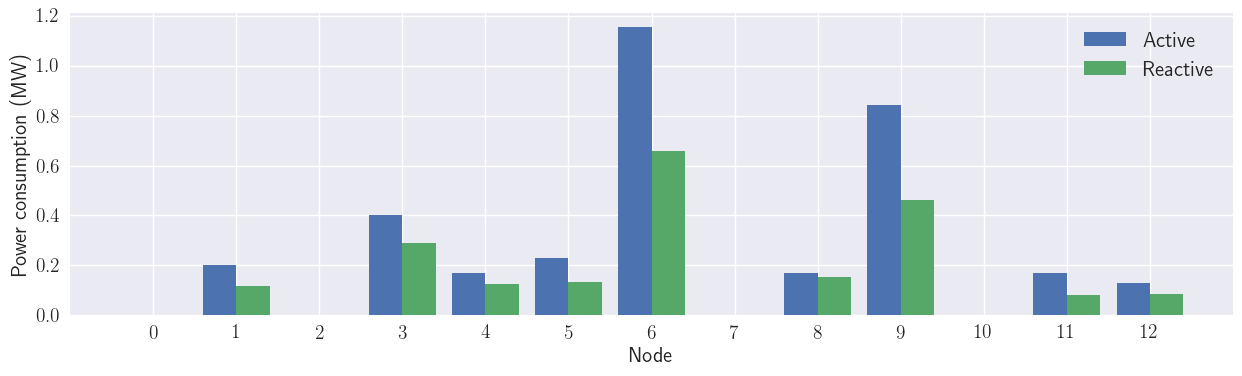

In [144]:
## Problem 1

# Plot active and reactive power consumption
plt.figure(num=1, figsize=(15, 4))
 
# create plot
plt.bar(j_idx-0.2, l_P, width=0.4, label='Active')
plt.bar(j_idx+0.2, l_Q, width=0.4, label='Reactive')
plt.xticks(j_idx)
plt.xlim([-1, 13])
plt.legend()
plt.xlabel('Node')
plt.ylabel('Power consumption (MW)')
plt.show()

In [186]:
## Problem 2

# Assumptions:
#   - Disregard the entire network diagram
#   - Balance supply and demand, without any network considerations
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)

# Define objective function
objective = Minimize(c @ s)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Balance power generation with power consumption
constraints += [sum(p) == sum(l_P), sum(q) == sum(l_Q)]

# Loop over each node
for jj in j_idx:
    
    # Non-negative power generation
    constraints += [p[jj] >= 0, q[jj] >= 0]
    # Compute apparent power from active & reactive power
    constraints += [s[jj] >= norm(hstack(p[jj], q[jj]))]

# Define problem and solve
prob2 = Problem(objective, constraints)
prob2.solve()

# Output Results
print("------------------- PROBLEM 2 --------------------")
print("--------------------------------------------------")
print(prob2.status)
print("Minimum Generating Cost : %4.2f"%(prob2.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW")
print(" ")
print("Total active power   : %1.3f"%(sum(l_P)),"MW   consumed | %1.3f"%(sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(sum(l_Q)),"MVAr consumed | %1.3f"%(sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(sum(l_S)),"MVA  consumed | %1.3f"%(sum(s.value)),"MVA  generated")

------------------- PROBLEM 2 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 255.36 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MW | s_0 = 1.054 MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW
Node 9 [Solar] Gen Power : p_9 = 2.565 MW | q_9 = 1.556 MW | s_9 = 3.000 MW
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated


In [304]:
## Problem 3

# Assumptions:
#   - Disregard L_ij, the squared magnitude of complex line current
#   - Disregard nodal voltage equation
#   - Disregard nodal voltage limits
#   - Disregard maximum line current
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# a switch for 3d
moreCapacity = False

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable(13, 13)
Q = Variable(13, 13)

# Define objective function
objective = Minimize(c @ s)

# Define constraints
# Apparent Power Limits
constraints = [s <= (s_max)]

# increasing the solar power capacity by 1MW
if moreCapacity == True:
    s_max_pro = np.hstack([s_max[:9], s_max[9]+1, np.zeros(3, dtype=int)])
    constraints = [s <= (s_max_pro)]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
               Q[0,0] == 0]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [P[i, jj] == l_P[jj] - p[jj] + A[jj, :] @ P[jj, :].T]
    constraints += [Q[i, jj] == l_Q[jj] - q[jj] + A[jj, :] @ Q[jj, :].T]

    # Compute apparent power from active & reactive power
    constraints += [s[jj] >= norm(hstack(p[jj], q[jj]))]

# Define problem and solve
prob3 = Problem(objective, constraints)
prob3.solve()

# Output Results
print("------------------- PROBLEM 3 --------------------")
print("--------------------------------------------------")
print(prob3.status)
print("Minimum Generating Cost : %4.2f"%(prob3.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
print(" ")
print("Total active power   : %1.3f"%(sum(l_P)),"MW   consumed | %1.3f"%(sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(sum(l_Q)),"MVAr consumed | %1.3f"%(sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(sum(l_S)),"MVA  consumed | %1.3f"%(sum(s.value)),"MVA  generated")

------------------- PROBLEM 3 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 255.36 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MW | s_0 = 1.054 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 2.565 MW | q_9 = 1.556 MW | s_9 = 3.000 MW || mu_s9 =  50 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated


In [305]:
## Show the dual variables
print('Dual variable mu_s:\n\n', constraints[0].dual_value)

Dual variable mu_s:

 [[  5.03141743e-08]
 [  2.08692718e+02]
 [  2.08692718e+02]
 [  7.62606095e-08]
 [  2.08692718e+02]
 [  2.08692718e+02]
 [  2.08692718e+02]
 [  2.08692718e+02]
 [  2.08692719e+02]
 [  4.99999999e+01]
 [  2.08692718e+02]
 [  2.08692718e+02]
 [  2.08692718e+02]]


In [306]:
## Problem 4

# Assumptions:
#   - Add back all previously disregarded terms and constraints
#   - Relax squared line current equation into inequality
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# a switch for 3d
changeVlim = False
v_max_new = 1.02
v_min_new = 0.98

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable(13, 13)
Q = Variable(13, 13)
L = Variable(13, 13)
V = Variable(13)

# Define objective function
objective = Minimize(c @ s)

# Define constraints
# Apparent Power Limits
constraints = [s <= (s_max)]

# Nodal voltage limits
constraints += [V <= v_max ** 2]
constraints += [V >= v_min ** 2]

if changeVlim == True:
    constraints = [s <= (s_max)]
    constraints += [V <= v_max_new ** 2]
    constraints += [V >= v_min_new ** 2]

# Squared line current limits
constraints += [L <= I_max ** 2]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
                Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [P[i, jj] == l_P[jj] - p[jj] + r[i, jj] * L[i, jj] + A[jj, :] @ P[jj, :].T]
    constraints += [Q[i, jj] == l_Q[jj] - q[jj] + x[i, jj] * L[i, jj] + A[jj, :] @ Q[jj, :].T]

    # Nodal voltage
    constraints += [V[jj] == V[i] + (r[i, jj] ** 2 + x[i, jj] ** 2) * L[i, jj] - 2 * (r[i, jj] * P[i, jj] + x[i, jj] * Q[i, jj])]
    
    # Squared current magnitude on lines
    constraints += [L[i, jj] >= quad_over_lin(hstack([P[i, jj], Q[i, jj]]), V[jj])]
    
    # Compute apparent power from active & reactive power
    constraints += [s[jj] >= norm(hstack(p[jj], q[jj]))]
    

# Define problem and solve
prob4 = Problem(objective, constraints)
prob4.solve()

# Output Results
print("------------------- PROBLEM 4 --------------------")
print("--------------------------------------------------")
print(prob4.status)
print("Minimum Generating Cost : %4.2f"%(prob4.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
print(" ")
print("Total active power   : %1.3f"%(sum(l_P)),"MW   consumed | %1.3f"%(sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(sum(l_Q)),"MVAr consumed | %1.3f"%(sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(sum(l_S)),"MVA  consumed | %1.3f"%(sum(s.value)),"MVA  generated")
print(" ")
for jj in j_idx:
    print("Node %2.0f"%(jj), "Voltage : %1.3f"%((V[jj].value)**0.5), "p.u.")

------------------- PROBLEM 4 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 299.69 USD
 
Node 0 [Grid]  Gen Power : p_0 = 1.568 MW | q_0 = 0.985 MW | s_0 = 1.852 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = -0.000 MW | s_3 = -0.000 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.941 MW | q_9 = 1.216 MW | s_9 = 2.290 MW || mu_s9 =   0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.509 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.201 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.142 MVA  generated
 
Node  0 Voltage : 1.000 p.u.
Node  1 Voltage : 0.967 p.u.
Node  2 Voltage : 0.963 p.u.
Node  3 Voltage : 0.963 p.u.
Node  4 Voltage : 0.962 p.u.
Node  5 Voltage : 0.960 p.u.
Node  6 Voltage : 0.957 p.u.
Node  7 Voltage : 0.957 p.u.
Node  8 Voltage : 0.957 p.u.
Node  9 Voltage : 0.964 p.u.
Node 10 Voltage : 0.955 p.u.
Node 11 Voltage : 0.954 p.u.
Node 

In [307]:
# check dual variables
print('constraint (8):\n', constraints[1].dual_value, '\n', constraints[2].dual_value)
print('\nconstraint (9):\n', constraints[3].dual_value)

constraint (8):
 [[  3.63743264e-08]
 [  2.24051636e-08]
 [  2.15307967e-08]
 [  2.15307214e-08]
 [  2.12328756e-08]
 [  2.08725455e-08]
 [  2.02368696e-08]
 [  2.02151555e-08]
 [  2.02367140e-08]
 [  2.17664077e-08]
 [  1.98373848e-08]
 [  1.96232894e-08]
 [  1.94724324e-08]] 
 [[  3.82251160e-08]
 [  1.17028408e-07]
 [  1.50413016e-07]
 [  1.50414854e-07]
 [  1.68001790e-07]
 [  1.96105031e-07]
 [  2.83497328e-07]
 [  2.83364330e-07]
 [  2.83508539e-07]
 [  1.41551843e-07]
 [  4.10384493e-07]
 [  5.40557580e-07]
 [  7.03114998e-07]]

constraint (9):
 [[  1.30873978e+02   7.89751909e-10   3.36506221e-09   3.36506221e-09
    3.36506221e-09   3.36506221e-09   3.36506221e-09   3.36506221e-09
    3.36506221e-09   3.36506221e-09   3.36506221e-09   3.36506221e-09
    3.36506221e-09]
 [  3.36506221e-09   3.36506221e-09   2.04466765e-09   3.36506221e-09
    5.97769813e-09   3.36506221e-09   4.09379557e-10   3.36506221e-09
    3.36506221e-09   3.36506221e-09   3.36506221e-09   3.36506221e-09
 

In [309]:
## Problem 5

# Assumptions:
#   - Assume solar generator at node 9 has uncertain power capacity
#   - Goal is to minimize generation costs, given by c^T s, in face of uncertainty

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable(13, 13)
Q = Variable(13, 13)
L = Variable(13, 13)
V = Variable(13)
y = vstack([Variable(2), s[9]])

# Define objective function
objective = Minimize(c @ s)

# Define constraints
# Apparent Power Limits
constraints = [s <= (s_max)]

# Nodal voltage limits
constraints += [V <= v_max ** 2]
constraints += [V >= v_min ** 2]

# Squared line current limits
constraints += [L <= I_max ** 2]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
                Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [P[i, jj] == l_P[jj] - p[jj] + r[i, jj] * L[i, jj] + A[jj, :] @ P[jj, :].T]
    constraints += [Q[i, jj] == l_Q[jj] - q[jj] + x[i, jj] * L[i, jj] + A[jj, :] @ Q[jj, :].T]

    # Nodal voltage
    constraints += [V[jj] == V[i] + (r[i, jj] ** 2 + x[i, jj] ** 2) * L[i, jj] - 2 * (r[i, jj] * P[i, jj] + x[i, jj] * Q[i, jj])]
    
    # Squared current magnitude on lines
    constraints += [L[i, jj] >= quad_over_lin(P[i, jj], V[jj]) + quad_over_lin(Q[i, jj], V[jj])]
    
    # Compute apparent power from active & reactive power
    constraints += [s[jj] >= norm(hstack(p[jj], q[jj]))]
    
# New constraints
abar = np.array([-1.25, -1.25, 1])
E = np.diag([1.25, 1.25, 0])
constraints += [abar @ y + norm(E.T @ y) <= 0]
constraints += [y[0] <= 1]
constraints += [y[0] >= 0]
constraints += [y[1] <= 1]
constraints += [y[1] >= 0]


# Define problem and solve
prob5 = Problem(objective, constraints)
prob5.solve()

# Output Results
print("------------------- PROBLEM 5 --------------------")
print("--------------------------------------------------")
print(prob5.status)
#print("Minimum Generating Cost : %4.2f"%(prob5.value),"USD")
#print(" ")
#print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
#print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
#print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
#print(" ")
#print("Total active power   : %1.3f"%(sum(l_P)),"MW   consumed | %1.3f"%(sum(p.value)),"MW   generated")
#print("Total reactive power : %1.3f"%(sum(l_Q)),"MVAr consumed | %1.3f"%(sum(q.value)),"MVAr generated")
#print("Total apparent power : %1.3f"%(sum(l_S)),"MVA  consumed | %1.3f"%(sum(s.value)),"MVA  generated")
#print(" ")
#for jj in j_idx:
    #print("Node %2.0f"%(jj), "Voltage : %1.3f"%((V[jj].value)**0.5), "p.u.")


------------------- PROBLEM 5 --------------------
--------------------------------------------------
infeasible
